In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import netket as nk
import numpy as np
import jax.numpy as jnp

from netket.operator.spin import sigmax, sigmay, sigmaz

import sys 
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/models')

from Afm_Model_functions import *
from vmc_2spins_sampler import Exchange_OP

import pickle

import jax
import matplotlib.pyplot as plt

In [11]:
L = 4

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,8,9,10,11]
}

Ha16, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True, parity=0., sublattice = None, make_rotation=False, exchange_XY=False)
print('the Hilbert space is: ', hi2d)
XX = Exchange_OP(hi2d, TriGraph)

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)
rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])

sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=32, sweep_size=3*hi2d.size)


the Hilbert space is:  Spin(s=1/2, N=16, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7fc9b03e99d0>)


In [ ]:
def SpinSpin(node_i, node_j, hilbert, make_rotation=False, sublattice=None):
    """
    Computes the spin-spin correlation operator between node_i and node_j using JAX.
    """
    spin = {'x': sigmax, 'y': sigmay, 'z': sigmaz}
    
    i, j = int(node_i), int(node_j)
    
    sx_i = spin['x'](hilbert, i)
    sx_j = spin['x'](hilbert, j)
    sy_i = spin['y'](hilbert, i)
    sy_j = spin['y'](hilbert, j)
    sz_i = spin['z'](hilbert, i)
    sz_j = spin['z'](hilbert, j)
    
    if make_rotation:
        same_sublattice = (i in sublattice and j in sublattice) or (i not in sublattice and j not in sublattice)
        sign = 1 if same_sublattice else -1
        correlation = sign * (sx_i @ sx_j + sy_i @ sy_j) + sz_i @ sz_j
    else:
        correlation = sx_i @ sx_j + sy_i @ sy_j + sz_i @ sz_j
    
    return correlation


# jit compatible version of the structure factor for one momentum:

def Create_Differences(graph):
    """
    input:
    graph: (netket.graph) the graph of the system

    return:
    the differences between the coordinates of the nodes
    """
    N_tot = graph.n_nodes
    differences = []
    for i in range(N_tot):
        for j in range(N_tot):
            differences.append(graph.positions[i] - graph.positions[j])
    return jnp.array(differences)


def Create_SpinSpin_Vec(wavefunction, hilbert, graph, make_rotation=False, sublattice=None):
    """
    input:
    graph: (netket.graph) the graph of the system
    make_rotation: (bool) if True, the rotation (marshall sign) of the spins is applied
    sublattice: (list) the sublattice on which the spins are to apply the spin

    return:
    the vector of the spin-spin correlation operators
    """
    N_tot = graph.n_nodes
    # hilbert = graph.hilbert
    spin_spin_vec = []
    for i in range(N_tot):
        for j in range(N_tot):
            spin_spin_vec.append(wavefunction.expect(SpinSpin(i, j, hilbert, make_rotation=make_rotation, sublattice=sublattice)).mean)
            # spin_spin_vec.append(SpinSpin(i, j, hilbert, make_rotation=make_rotation, sublattice=sublattice))
    
    # we cannot store operaotrs in jnp.array, but it is possible to store them in a numpy.array
    return jnp.array(spin_spin_vec)


def Single_Struc_Fac(k, differences, spin_spin_vec, Ntot):
    """
    input:
    k: (np.darray) the wave vector q
    differences: (np.darray) the differences between the coordinates of the nodes
    spin_spin_vec: (np.darray) the vector of the spin-spin correlation operators

    return:
    the structure factor S(q)
    """
    phases = jnp.exp(1.0j * jnp.dot(differences, k))
    return jnp.dot(phases, spin_spin_vec) / Ntot
    


def Momentum_Grid(arr):
    # Create the meshgrid
    X, Y = jnp.meshgrid(arr, arr, indexing="ij")  # 'ij' ensures correct order

    # Flatten and stack as (x, y) pairs
    grid = jnp.column_stack((X.ravel(), Y.ravel()))
    return grid


# this is how you call vmap afterwards:
# this is how you call vmap afterwards:
# g = nk.graph.Hypercube(length=2, n_dim=2, pbc=True)
# hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
# vs = nk.vqs.MCState(sa, model, n_samples=2**10)

# ds = Create_Differences(g)
# sss = Create_SpinSpin_Vec(vs,hi, g)
# result= vmap(Single_Struc_Fac, in_axes=(0, None, None, None))(Momentum_Grid(jnp.linspace(-jnp.pi, jnp.pi, 100)), ds, sss, hi.size)

We try to compute the Structure factor for an rbm quantum state on the 4x4 Triangular lattice:

In [13]:
vs_rbm = nk.vqs.MCState(sampler = sa_HaEx5050, model = nk.models.RBM(alpha=4, param_dtype=complex), n_samples=2**12, n_discard_per_chain=16)

In [17]:
with open('log_HaEx5050_rbm_alpha4.0.pickle', 'rb') as handle:
    params = pickle.load(handle)

vs_rbm.variables = params

In [18]:
for _ in range(4):
    vs_rbm.sample()
    vs_rbm.reset()

In [20]:
vs_rbm.expect(Ha16)

-25.930+0.014j ± 0.026 [σ²=2.919, R̂=1.0038]

In [75]:
k_grid = Momentum_Grid(jnp.linspace(-1., 1., 10) * 4 * jnp.pi / 3)
diffs = Create_Differences(TriGraph)
SS_Vec = Create_SpinSpin_Vec(vs_rbm, hi2d, TriGraph)

In [79]:
k_grid

Array([[-4.1887902 , -4.1887902 ],
       [-4.1887902 , -3.25794794],
       [-4.1887902 , -2.32710567],
       [-4.1887902 , -1.3962634 ],
       [-4.1887902 , -0.46542113],
       [-4.1887902 ,  0.46542113],
       [-4.1887902 ,  1.3962634 ],
       [-4.1887902 ,  2.32710567],
       [-4.1887902 ,  3.25794794],
       [-4.1887902 ,  4.1887902 ],
       [-3.25794794, -4.1887902 ],
       [-3.25794794, -3.25794794],
       [-3.25794794, -2.32710567],
       [-3.25794794, -1.3962634 ],
       [-3.25794794, -0.46542113],
       [-3.25794794,  0.46542113],
       [-3.25794794,  1.3962634 ],
       [-3.25794794,  2.32710567],
       [-3.25794794,  3.25794794],
       [-3.25794794,  4.1887902 ],
       [-2.32710567, -4.1887902 ],
       [-2.32710567, -3.25794794],
       [-2.32710567, -2.32710567],
       [-2.32710567, -1.3962634 ],
       [-2.32710567, -0.46542113],
       [-2.32710567,  0.46542113],
       [-2.32710567,  1.3962634 ],
       [-2.32710567,  2.32710567],
       [-2.32710567,

In [76]:
Sq_rbm = jax.vmap(Single_Struc_Fac, in_axes=(0, None, None, None))(k_grid, diffs, SS_Vec, hi2d.size)

In [77]:
Sq_rbm.shape

(100,)

In [ ]:
ks = jnp.linspace(-1., 1., 10) * 4 * jnp.pi / 3

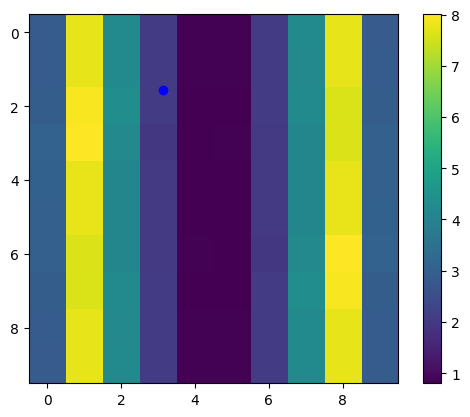

In [ ]:
ticks = jnp.linspace(-1., 1., 10) * 4 * jnp.pi / 3
plt.imshow(Sq_rbm.reshape((10, 10)).real.T, cmap='viridis')

# plt.imshow(Sq_rbm.reshape((10, 10)).real, extent = [ks.min(), ks.max(), ks.min(), ks.max()], cmap='viridis')
# plt.xticks(ticks=jnp.linspace(0, 99, 5), labels=[f"{tick:.2f}" for tick in jnp.linspace(-1., 1., 5) * 4 * jnp.pi / 3])
# plt.yticks(ticks=jnp.linspace(0, 99, 5), labels=[f"{tick:.2f}" for tick in jnp.linspace(-1., 1., 5) * 4 * jnp.pi / 3])
# plt.plot(np.pi, np.pi/2, 'bo')
plt.colorbar()

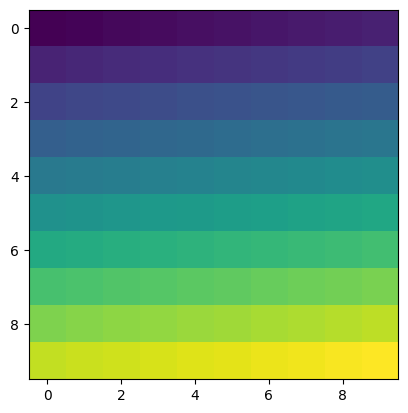

In [82]:
plt.imshow(np.arange(0, 100).reshape((10, 10)))

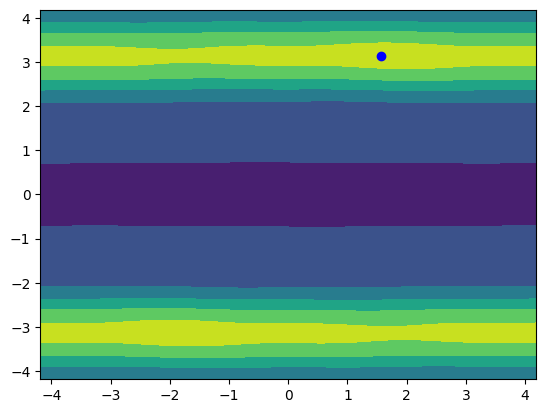

In [65]:
xs, ys = jnp.meshgrid(jnp.linspace(-1., 1., 200) * 4 * jnp.pi / 3, jnp.linspace(-1., 1., 200) * 4 * jnp.pi / 3)
plt.plot(np.pi/2, np.pi, 'bo')

plt.contourf(xs, ys, Sq_rbm.reshape((200, 200)).real, cmap='viridis')

In [40]:
reshaped_grid[:,0,0]

Array([-3.14159265, -3.07812614, -3.01465962, -2.9511931 , -2.88772658,
       -2.82426006, -2.76079354, -2.69732703, -2.63386051, -2.57039399,
       -2.50692747, -2.44346095, -2.37999443, -2.31652792, -2.2530614 ,
       -2.18959488, -2.12612836, -2.06266184, -1.99919533, -1.93572881,
       -1.87226229, -1.80879577, -1.74532925, -1.68186273, -1.61839622,
       -1.5549297 , -1.49146318, -1.42799666, -1.36453014, -1.30106362,
       -1.23759711, -1.17413059, -1.11066407, -1.04719755, -0.98373103,
       -0.92026451, -0.856798  , -0.79333148, -0.72986496, -0.66639844,
       -0.60293192, -0.53946541, -0.47599889, -0.41253237, -0.34906585,
       -0.28559933, -0.22213281, -0.1586663 , -0.09519978, -0.03173326,
        0.03173326,  0.09519978,  0.1586663 ,  0.22213281,  0.28559933,
        0.34906585,  0.41253237,  0.47599889,  0.53946541,  0.60293192,
        0.66639844,  0.72986496,  0.79333148,  0.856798  ,  0.92026451,
        0.98373103,  1.04719755,  1.11066407,  1.17413059,  1.23